In [1]:
import pandas as pd 
import requests
import time
import json
import talib
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns',None)

In [2]:
# 获取永续合约价格
def get_perpetualprice(platform, symbol):
    if platform == 'huobi':
        now = int(time.time())
        start_time = now - 86400*300
        contract_code = "{}-usdt".format(symbol).upper()
        url = huobifuture_api_url + '/linear-swap-ex/market/history/kline?contract_code={}&period=1day&from={}&to={}'.format(
            contract_code, start_time, now)
        res = requests.get(url)
        resdict = json.loads(res.content.decode())
        high_price = [i['high'] for i in resdict['data']]
        low_price =[i['low'] for i in resdict['data']]
        close_price = [i['close'] for i in resdict['data']]
        return np.array(high_price),np.array(low_price),np.array(close_price)
    elif platform == "T8ex":
        contract_id_dict = {'BTC': 1, 'ETH': 2, 'LINK': 3, 'EOS': 4, 'FIL': 5, 'LTC': 6, 'UNI': 7, 'DOT': 8, 'DOGE': 9}
        contract_id = contract_id_dict[symbol.upper()]
        now = int(time.time())
        start_time = now - 300
        url = T8ex_kline_url + "?contractId={}&from={}&to={}&resolution={}".format(contract_id, start_time * 1000, now * 1000, 1)
        res = requests.get(url).json()
        if res:
            close_price = res[-1][-2]
            return close_price

In [3]:
symbols= ['btc','eth','link','eos','fil','ltc','dot','doge']
huobifuture_api_url = 'https://api.btcgateway.pro'
symbol_data=get_perpetualprice("huobi","doge")

In [4]:
df=pd.DataFrame()
df['high']=symbol_data[0]
df['low']=symbol_data[1]
df['close']=symbol_data[2]

In [5]:
high=symbol_data[0]
low=symbol_data[1]
close=symbol_data[2]

In [6]:
df['atr']=atr=talib.ATR(high,low,close,10)

In [7]:
df['high_20']=np.array(df['high'].rolling(20).max())

In [8]:
df['low_20']=np.array(df['low'].rolling(20).min())

In [9]:
df['high_diff']=df['high_20']-df['close']

In [10]:
df['low_diff']=df['close']-df['low_20']

In [11]:
df['dontbuy']=np.where(df['high_diff']>3*df['atr'].shift(),1,0)

In [12]:
df['dontsell']=np.where(df['low_diff']>3*df['atr'].shift(),1,0)

In [13]:
diff,dea,macd=talib.MACD(close,3,7,7)

In [14]:
df['diff']=diff
df['dea']=dea
df['macd']=macd

In [15]:
cross=[]
for i in range(len(diff)):
    if diff[i]>0 and dea[i]>0 and macd[i]>0: 
        cross.append(1)
    elif diff[i]<0 and dea[i]<0 and macd[i]<0:
        cross.append(-1)
    else:
        cross.append(0)

In [16]:
df['cross']=np.array(cross)

In [17]:
df['sell']=np.where((df['cross']==-1)&(df['dontsell']!=1),1,0)
df['buy']=np.where((df['cross']==1)&(df['dontbuy']!=1),1,0)

In [18]:
df['return']=np.log(df['close']/(df['close'].shift()))

In [19]:
buy_list=df['buy'].values.tolist()
sell_list=df['sell'].values.tolist()

In [20]:
#双向交易
flag=0
direction=[]
for i in range(len(buy_list)):
    if flag==0:
        if buy_list[i]==1 :
            direction.append(1)
            flag=1
        elif sell_list[i]==1:
            direction.append(-1)
            flag=-1
        else:
            direction.append(0)
    elif flag==1:
        if buy_list[i]==1 : 
            direction.append(1)
        elif buy_list[i]==0 :
            direction.append(0)
            flag=0
        else:
            direction.append(1)
    elif flag==-1:
        if sell_list[i]==0:
            direction.append(0)
            flag=0
        elif sell_list[i]==1:
            direction.append(-1)
        else:
            direction.append(-1)

In [21]:
df['direction']=np.array(direction)

In [22]:
df

,high,low,close,atr,high_20,low_20,high_diff,low_diff,dontbuy,dontsell,diff,dea,macd,cross,sell,buy,return,direction
0,0.008336,0.007854,0.008171,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0,0,0,NaN,0
1,0.010143,0.008084,0.009560,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0,0,0,0.156996,0
2,0.009884,0.008634,0.008701,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0,0,0,-0.094150,0
3,0.009582,0.008347,0.009419,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0,0,0,0.079291,0
4,0.009487,0.008802,0.009178,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0,0,0,-0.025920,0
5,0.009404,0.008897,0.009154,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0,0,0,-0.002618,0
6,0.009723,0.008967,0.009231,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0,0,0,0.008376,0
7,0.009280,0.008583,0.008685,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0,0,0,-0.060970,0
8,0.009115,0.008247,0.008325,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0,0,0,-0.042334,0
9,0.008750,0.007530,0.008554,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,0,0,0,0.027136,0


In [23]:
df.dropna(inplace=True)

In [24]:
df['Strategy']=df['return']*df['direction'].shift(1)*1

<AxesSubplot:>

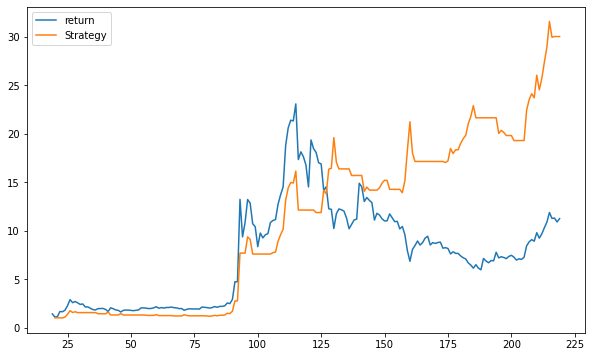

In [25]:
df[['return','Strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))